# Module

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

# Load Data

### Dataset DownLoad

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
cd drive/MyDrive/cs231n/kaggle/plant-pathology-2020-fgvc7

/content/drive/MyDrive/cs231n/kaggle/plant-pathology-2020-fgvc7


In [ ]:
import numpy as np 
import pandas as pd 
import os

test_df = pd.read_csv("./test.csv")
train_df = pd.read_csv("./train.csv")

train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
# healthy, multiple_diseases, rust, scab 컬럼을 합해서 sum을 만들고 sum이 1보다 큰지, 아니면 0인지 확인. 
train_df['sum'] = train_df['healthy'] + train_df['multiple_diseases'] + train_df['rust'] + train_df['scab']
train_df[(train_df['sum'] > 1) | (train_df['sum']==0)] 

,image_id,healthy,multiple_diseases,rust,scab,sum


In [ ]:
pd.set_option("max_colwidth", 100)

IMAGE_DIR = './images'
train_df['path'] = IMAGE_DIR + '/' + train_df['image_id'] + '.jpg'
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,sum,path
0,Train_0,0,0,0,1,1,./images/Train_0.jpg
1,Train_1,0,1,0,0,1,./images/Train_1.jpg
2,Train_2,1,0,0,0,1,./images/Train_2.jpg
3,Train_3,0,0,1,0,1,./images/Train_3.jpg
4,Train_4,1,0,0,0,1,./images/Train_4.jpg


In [ ]:
def get_label(x):
    if x['healthy'] == 1:
        return 'healthy'
    elif x['multiple_diseases'] == 1:
        return 'multiple_diseases'
    elif x['rust'] == 1:
        return 'rust'
    elif x['scab'] == 1:
        return 'scab'
    else: return 'None'


train_df['label'] = train_df.apply(lambda x:get_label(x), axis=1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,sum,path,label
0,Train_0,0,0,0,1,1,./images/Train_0.jpg,scab
1,Train_1,0,1,0,0,1,./images/Train_1.jpg,multiple_diseases
2,Train_2,1,0,0,0,1,./images/Train_2.jpg,healthy
3,Train_3,0,0,1,0,1,./images/Train_3.jpg,rust
4,Train_4,1,0,0,0,1,./images/Train_4.jpg,healthy


In [ ]:
## 학습 이미지 건수 및 label별 건수
print('train shape:', train_df.shape)
print('label 별 건수')
train_df['label'].value_counts()

train shape: (1821, 8)
label 별 건수


rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

### 원본 이미지 시각화
* 녹병균 (Rust), 박테리아성 질환(scab), 복합질병(multiple_diseases), 건강(healthy)
* 이미지 size는 (1365, 2048)

(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)


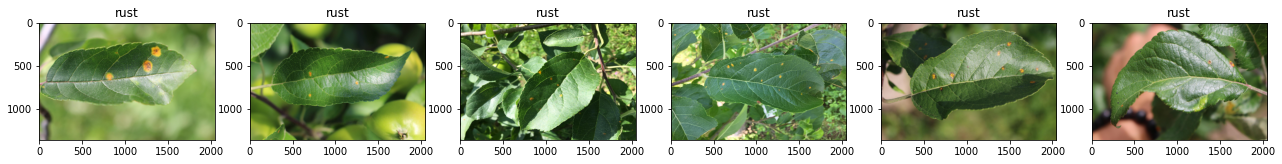

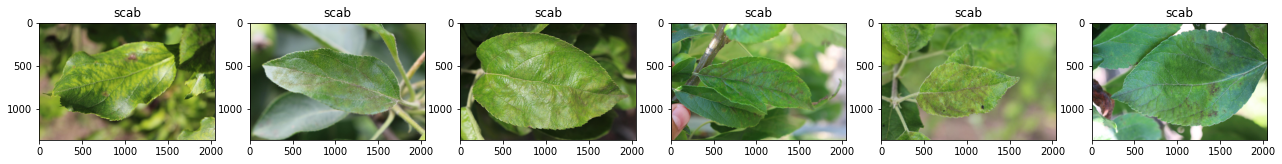

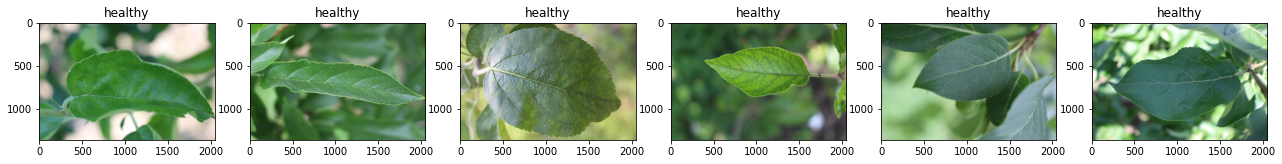

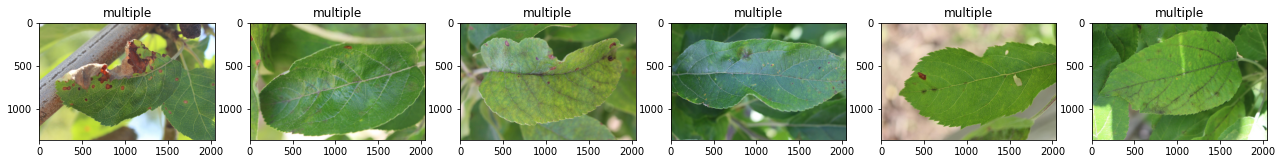

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_grid_images(image_path_list, augmentor=None, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        if augmentor is not None:
            image = augmentor(image)
        axs[i].imshow(image)
        #axs[i].axis('off')
        axs[i].set_title(title)
        print(image.shape)
        
rust_image_list = train_df[train_df['label']=='rust']['path'].iloc[:6].tolist()
scab_image_list = train_df[train_df['label']=='scab']['path'].iloc[:6].tolist()
healthy_image_list = train_df[train_df['label']=='healthy']['path'].iloc[:6].tolist()
multiple_image_list = train_df[train_df['label']=='multiple_diseases']['path'].iloc[:6].tolist()

show_grid_images(rust_image_list, ncols=6, title='rust')
show_grid_images(scab_image_list, ncols=6, title='scab')
show_grid_images(healthy_image_list, ncols=6, title='healthy')
show_grid_images(multiple_image_list, ncols=6, title='multiple')

### 이미지 Augmentation 적용. 
* cutout과 같은 noise는 나뭇잎의 병균 반점과 헷갈릴 수 있으므로 사용하지 않음. 
* 전체 이미지가 파란색 계열이고 병균 반점이 특정 색깔을 가지고 있으므로 색상의 변화는 적용하지 않음. 
* 전반적으로 판별하려는 나뭇잎이 전체 이미지의 중앙에 와있음. scale등의 적용 고려. 

In [ ]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(3)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ]),
}

use_gpu = torch.cuda.is_available()

# show_grid_images(rust_image_list, augmentor=None, ncols=6, title='original rust')
# show_grid_images(rust_image_list, augmentor=data_transforms['train'], ncols=6, title='augmented rust')

# show_grid_images(scab_image_list, augmentor=None, ncols=6, title='original scab')
# show_grid_images(scab_image_list, augmentor=data_transforms['train'], ncols=6, title='augmented scab')

In [ ]:
# import albumentations as A

# augmentor_01 = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
#     A.Blur(p=0.2)
# ])

# show_grid_images(rust_image_list, augmentor=None, ncols=6, title='original rust')
# show_grid_images(rust_image_list, augmentor=augmentor_01, ncols=6, title='augmented rust')

# show_grid_images(scab_image_list, augmentor=None, ncols=6, title='original scab')
# show_grid_images(scab_image_list, augmentor=augmentor_01, ncols=6, title='augmented scab')

### Dataset 생성
* 기존엔 image size가 높이와 너비가 동일하였으나, 이번엔 높이와 너비가 다를 수 있을 경우를 고려하여 image_size를 튜플로 입력
* opencv의 resize()는 인자로 이미지 크기를 입력 받는데 가로x세로(너비x높이)의 개념으로 입력 받음. 이미지 배열의 경우는 행x열(높이x너비) 이므로 resize()호출시 이를 감안할것. 
* 캐글 컴피티션에 테스트 데이터의 결과를 submit하므로 테스트 데이트의 Label이 없음. 때문에 Dataset의 label_batch 값이 None이 될 수 있는 경우를 감안해서 코드 재수정 필요. 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import sklearn 
import cv2

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. image size는 (높이, 너비)로 수정. 
class Plant_Dataset(Dataset):
    def __init__(self, image_filenames, labels, image_size=(224,224), 
                 augmentor=None, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_size = image_size
        self.augmentor = augmentor
        self.pre_func = pre_func
    
    # Dataset을 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다(ceil).
        return len(self.labels)
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name = self.image_filenames[index]
        if self.labels is not None:
            label = self.labels[index]
            label = torch.tensor(label)
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
        if self.augmentor is not None:
            image = self.augmentor(image)
        #crop 시 잘린 이미지가 원본 이미지와 다르게 되므로 augmentation 적용 후 resize() 적용. 
        #image = cv2.resize(image, (self.image_size, self.image_size))
        # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
        if self.pre_func is not None:
            image = self.pre_func(image)
            
        return image, label

### 전체 DataFrame을 학습과 테스트용 DataFrame으로 분리. 학습 DataFrame은 다시 학습과 검증용으로 분리 
* train_test_split()을 이용하여 전체의 20%를 테스트 데이터로 할당. 

In [ ]:
from sklearn.model_selection import train_test_split

def get_train_valid(train_df, valid_size=0.2, random_state=1422):
    train_path = train_df['path'].values
    # 별도의 원핫인코딩을 하지 않고  'healthy', 'multiple_diseases', 'rust', 'scab' 컬럼들을 모두 Numpy array로 변환하는 수준으로 label을 원핫 인코딩 적용. 
    train_label = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
    
    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=valid_size, random_state=random_state)
    print('tr_path shape:', tr_path.shape, 'tr_label shape:', tr_label.shape, 'val_path shape:', val_path.shape, 'val_label shape:', val_label.shape)
    return tr_path, val_path, tr_label, val_label


# image size는 224x224로 Dataset 생성. 
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=1422)

tr_ds = Plant_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, 
                          augmentor=data_transforms['train'])
val_ds = Plant_Dataset(val_path, val_label, image_size=IMAGE_SIZE, 
                      augmentor=data_transforms['val'])
tr_dl = torch.utils.data.DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)


# Model

In [ ]:
from torchvision.models import resnet50, mobilenet
from torch.optim import Adam, RMSprop
from torch.functional import F
import torch.nn as nn
import torch

torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


ResNet = resnet50(pretrained=True)
for params in ResNet.parameters():
      params.requires_grad = False
ResNet.to(device)

class ResNet_plant(nn.Module):
  def __init__(self, in_shape=(224,224,3), n_classes=4):
    super().__init__()
    self.fc1 = nn.Linear(1000, 640)
    self.fc2 = nn.Linear(640, n_classes)
    self.dropout = nn.Dropout2d()

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Train

In [ ]:
N_EPOCHS = 30

def train_model(model_type, train_df, epochs, initial_lr=0.001, augmentor=None, input_pre_func=None):
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size=0.2, random_state=1422)
    
    tr_ds = Plant_Dataset(tr_path, tr_label, image_size=IMAGE_SIZE, 
                          augmentor=augmentor['train'], pre_func=input_pre_func)
    val_ds = Plant_Dataset(val_path, val_label, image_size=IMAGE_SIZE, 
                          augmentor=augmentor['val'], pre_func=input_pre_func)
    
    tr_dl = torch.utils.data.DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    ds = {'train':tr_dl,
          'val'  :val_dl}
    history = {'train_loss':[], 'train_acc':[],
               'val_loss':[],   'val_acc':[]}

    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', model_type, ' 생성 및 학습 수행 ########')
    model = ResNet_plant().to(device)
    optimizer = Adam(model.parameters(), lr=initial_lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      tr_size = 0
      val_size = 0
      epoch_tr_loss = 0
      epoch_val_loss = 0
      epoch_tr_acc = 0
      epoch_val_acc = 0

      for mode in ['train', 'val']:
        if mode == 'train':
          model.train()
        else :
          model.eval()
        
        for inputs, labels in ds[mode]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          with torch.set_grad_enabled(mode=='train'):
            outputs = ResNet(inputs)
            outputs = model(outputs)
            labels = labels.type(torch.long)
            print(labels)
            loss = criterion(outputs, labels)

            if mode=='train':
              loss.backward()
              optimizer.step()
            
          _, y = torch.max(outputs,1)
          if mode=='train':
            tr_size += 1
            epoch_tr_loss += loss.item() * len(inputs)
            epoch_tr_acc  += torch.sum(y==labels.data)
          else:
            val_size += 1
            epoch_val_loss += loss.item() * len(inputs)
            epoch_val_acc  += torch.sum(y==labels.data)
      
      print(f"{epoch+1}th epoch... tr_loss : {epoch_tr_loss/tr_size}, val_loss : {epoch_val_loss/val_size}, tr_acc : {epoch_tr_acc/tr_size}, val_acc : {epoch_val_acc/val_size}")

      history['train_loss'].append(epoch_tr_loss / tr_size)
      history['train_acc'].append(epoch_tr_acc / tr_size)
      history['val_loss'].append(epoch_val_loss / val_size)
      history['val_acc'].append(epoch_val_acc / val_size)

    return model, history

In [ ]:
resnet_model, resnet_history = train_model(model_type='resnet50', train_df=train_df, epochs=10, initial_lr=0.0001, augmentor=data_transforms)

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)
####### resnet50  생성 및 학습 수행 ########
tensor([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
      

RuntimeError: ignored

In [ ]:
plt.plot(resnet_history['val_loss'])
plt.show()